In [1]:
import pandas as pd
import numpy as np
from model_day import get_data, walk_forward_validation_seq
import xgboost as xgb

Found cached dataset text (C:/Users/WINSTON-ITX/.cache/huggingface/datasets/boomsss___text/boomsss--SPX_full_30min-37ae67efd8a1cc91/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


In [2]:
data, df_final, final_row = get_data()

Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 999.15it/s]


In [3]:
data['ClosePct'] = (data['Close'] / data['PrevClose']) - 1
data['HighPct'] = (data['High'] / data['PrevClose']) - 1
data['LowPct'] = (data['Low'] / data['PrevClose']) - 1
data['ClosePct'] = data['ClosePct'].shift(-1)

In [4]:
res1, model1, model2 = walk_forward_validation_seq(df_final.dropna(axis=0), 'Target_clf', 'Target', 100, 1)

LR Model: 100%|██████████| 1178/1178 [00:03<00:00, 385.55it/s]
d:\Projects\gamedayspx\model_day.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_merge['RegrModelOut'] = for_merge['RegrModelOut'] > 0
CLF Model: 100%|██████████| 1078/1078 [00:09<00:00, 119.55it/s]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

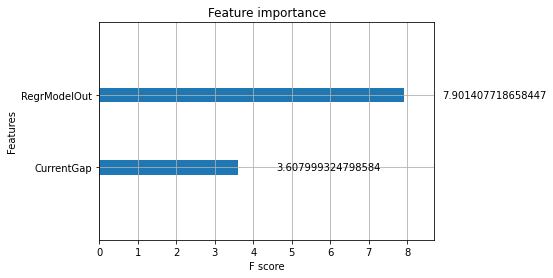

In [5]:
xgb.plot_importance(model2, importance_type='gain')

In [6]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# st.subheader('New Prediction')

# df_probas = res1.groupby(pd.qcut(res1['Predicted'],5)).agg({'True':[np.mean,len,np.sum]})
df_probas = res1.groupby(pd.cut(res1['Predicted'],[-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf])).agg({'True':[np.mean,len,np.sum]})
df_probas.columns = ['PctGreen','NumObs','NumGreen']

roc_auc_score_all = roc_auc_score(res1['True'].astype(int), res1['Predicted'].values)
precision_score_all = precision_score(res1['True'].astype(int), res1['Predicted'] > 0.5)
recall_score_all = recall_score(res1['True'].astype(int), res1['Predicted'] > 0.5)
len_all = len(res1)

res2_filtered = res1.loc[(res1['Predicted'] > 0.625) | (res1['Predicted'] <= 0.375)]

roc_auc_score_hi = roc_auc_score(res2_filtered['True'].astype(int), res2_filtered['Predicted'].values)
precision_score_hi = precision_score(res2_filtered['True'].astype(int), res2_filtered['Predicted'] > 0.5)
recall_score_hi = recall_score(res2_filtered['True'].astype(int), res2_filtered['Predicted'] > 0.5)
len_hi = len(res2_filtered)

df_performance = pd.DataFrame(
    index=[
        'N',
        'ROC AUC',
        'Precision',
        'Recall'
    ],
    columns = [
        'All',
        'High Confidence'
    ],
    data = [
        [len_all, len_hi],
        [roc_auc_score_all, roc_auc_score_hi],
        [precision_score_all, precision_score_hi],
        [recall_score_all, recall_score_hi]
    ]
).round(2)

def get_acc(t, p):
    if t == False and p <= 0.375:
        return '✅'
    elif t == True and p > 0.625:
        return '✅'
    elif t == False and p > 0.625:
        return '❌'
    elif t == True and p <= 0.375:
        return '❌'
    else:
        return '🟨'

perf_daily = res1.copy()
perf_daily['Accuracy'] = [get_acc(t, p) for t, p in zip(perf_daily['True'], perf_daily['Predicted'])]

In [7]:
perf_daily1 = perf_daily.merge(data['ClosePct'], left_index=True, right_index=True)

In [8]:
res2 = res1.merge(data[['ClosePct','HighPct','LowPct']], left_index=True, right_index=True)

In [9]:
int_labels = ['(-∞, .20]', '(.20, .40]', '(.40, .60]', '(.60, .80]', '(.80, ∞]']
# df_probas = res1.groupby(pd.qcut(res1['Predicted'],5)).agg({'True':[np.mean,len,np.sum]})
df_probas = res2.groupby(pd.cut(res2['Predicted'], bins = [-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf], labels = int_labels)).agg({'True':[np.mean,len,np.sum],'ClosePct':[np.mean], 'HighPct':[np.mean], 'LowPct':[np.mean]})
df_probas.columns = ['PctGreen','NumObs','NumGreen','AvgPerf','AvgHigh','AvgLow']

In [10]:
df_probas

PctGreen  NumObs  NumGreen   AvgPerf   AvgHigh    AvgLow
Predicted                                                           
(-∞, .20]   0.214286     112        24 -0.012956  0.009253 -0.007881
(.20, .40]  0.322709     251        81 -0.004048  0.006433 -0.005791
(.40, .60]  0.504630     216       109 -0.000173  0.006079 -0.006083
(.60, .80]  0.645022     231       149  0.002680  0.006207 -0.005687
(.80, ∞]    0.791045     268       212  0.009038  0.006807 -0.007949

In [11]:
res2['Quantile'] = pd.cut(res2['Predicted'], bins = [-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf], labels = int_labels)

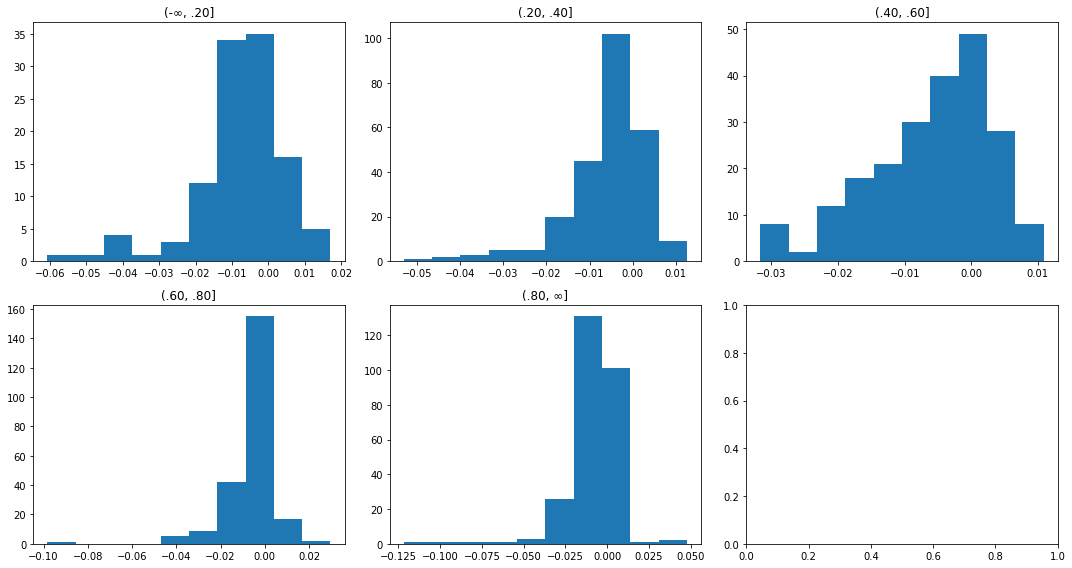

In [12]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'res2' with the columns 'Quantile' and 'ClosePct'
# Assuming you have a list 'int_labels' containing the unique values for 'Quantile'

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Loop through the 'int_labels' and plot the histograms in each subplot
for i, lbl in enumerate(int_labels):
    # Get the subplot position based on the index i
    row = i // 3
    col = i % 3
    
    # Filter the DataFrame based on the specified value
    data_subset = res2.loc[res2['Quantile'] == lbl, 'LowPct']
    
    # Plot the histogram in the corresponding subplot
    axs[row, col].hist(data_subset)
    axs[row, col].set_title(lbl)

# Add some space between the subplots
plt.tight_layout()

# Show the plot
plt.show()


In [39]:
# Investigate EM
data['VIX_EM'] = data['Close'] * (data['Close_VIX']/100) * (np.sqrt( 1 ) / np.sqrt(252))
data['VIX_EM_High'] = data['Close'] + data['VIX_EM']
data['VIX_EM_Low'] = data['Close'] - data['VIX_EM']

data['VIX_EM_125'] = data['VIX_EM'] * 1.25
data['VIX_EM_125_High'] = data['Close'] + data['VIX_EM_125']
data['VIX_EM_125_Low'] = data['Close'] - data['VIX_EM_125']

data['VIX_EM_15'] = data['VIX_EM'] * 1.5
data['VIX_EM_15_High'] = data['Close'] + data['VIX_EM_15']
data['VIX_EM_15_Low'] = data['Close'] - data['VIX_EM_15']

data['VIX_EM'] = data['VIX_EM'].shift(1)
data['VIX_EM_High'] = data['VIX_EM_High'].shift(1)
data['VIX_EM_Low'] = data['VIX_EM_Low'].shift(1)

data['VIX_EM_15'] = data['VIX_EM_15'].shift(1)
data['VIX_EM_15_High'] = data['VIX_EM_15_High'].shift(1)
data['VIX_EM_15_Low'] = data['VIX_EM_15_Low'].shift(1)

data['VIX_EM_125'] = data['VIX_EM_125'].shift(1)
data['VIX_EM_125_High'] = data['VIX_EM_125_High'].shift(1)
data['VIX_EM_125_Low'] = data['VIX_EM_125_Low'].shift(1)

In [33]:
data[['VIX_EM','VIX_EM_15','VIX_EM_15_High','Close']]

VIX_EM  VIX_EM_15  VIX_EM_15_High        Close
index                                                        
2018-07-02        NaN        NaN             NaN  2726.709961
2018-07-03  26.795587  40.193381     2766.903342  2713.219971
2018-07-05  27.585969  41.378954     2754.598925  2736.610107
2018-07-06  25.806818  38.710227     2775.320335  2759.820068
2018-07-09  23.244055  34.866083     2794.686151  2784.169922
...               ...        ...             ...          ...
2023-07-28  41.188099  61.782148     4599.192304  4582.229980
2023-07-31  38.477492  57.716238     4639.946219  4588.959961
2023-08-01  39.401237  59.101856     4648.061817  4576.729980
2023-08-02  40.161151  60.241726     4636.971706  4513.390137
2023-08-03  45.746582  68.619873     4582.010010  4501.890137

[1281 rows x 4 columns]

In [34]:
# How often did price close within EM?
len(data.query('Close <= VIX_EM_High & Close >= VIX_EM_Low')) / len(data)

0.8032786885245902

In [35]:
# How often was EM tested?
len(data.query('High > VIX_EM_High | Low < VIX_EM_Low')) / len(data)

0.33099141295862605

In [40]:
# How often did price close within EM?
len(data.query('Close <= VIX_EM_125_High & Close >= VIX_EM_125_Low')) / len(data)

0.8930523028883685

In [41]:
# How often was EM tested?
len(data.query('High > VIX_EM_125_High | Low < VIX_EM_125_Low')) / len(data)

0.19750195160031225

In [42]:
# How often did price close within EM?
len(data.query('Close <= VIX_EM_15_High & Close >= VIX_EM_15_Low')) / len(data)

0.9383294301327089

In [43]:
# How often was EM tested?
len(data.query('High > VIX_EM_15_High | Low < VIX_EM_15_Low')) / len(data)

0.10772833723653395